In [19]:
# TRIANGULAR LATTICE APPROACH 2

In [67]:
import numpy as np
import matplotlib.pyplot as plt
import numba
from numba import njit
from scipy.ndimage import convolve, generate_binary_structure
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

In [68]:
class ProductRNN1(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers=1):
        super(ProductRNN1, self).__init__()
        self.rnn = nn.RNN(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, 2)  # Output 2 numbers: one for each +1, -1

    def forward(self, bj, x):
        x = x.view(x.size(0), -1,1) # flatten + transpose
        # print(((x+1)/2).shape)
        # print(x[:,0:-1,:].shape)
        # Zeros=torch.zeros(x.size(0), 1, 1)
        #bj.view(-1,1,1)
        # print(x.shape)
        # print(bj.shape)
        x_0=torch.cat((bj.view(-1,1,1),x[:,0:-1,:]), dim=1)
        # print(x_0)
        # x_0=torch.cat((Zeros,x[:,0:-1,:]), dim=1)
        # print(bj.view(-1,1,1).shape)
        h0 = torch.zeros(self.rnn.num_layers, x.size(0), self.rnn.hidden_size).to(x.device) # (self.rnn.num_layers, x.size(0), self.rnn.hidden_size) for x=(batch_size, sequence_length, input_size); x.size(0)==batch_size
        # print(x)
        out, _ = self.rnn(x_0, h0)
        # print(out.shape)
        out = self.fc(out) # for o/p of each time stamp, we have len(hidden_state) o/p. Feeding them to a linear layer and getting single output for each tiemstamp 
        # print(out.shape)
        out = F.log_softmax(out, dim=2) # normalizing o/p at each time stamp
        extracted_values = out.gather(dim=2, index=((x+1)/2).type(torch.int64))
        # print(extracted_values.shape)
        sum_result = extracted_values.sum(dim=1)
        return sum_result

    def generate_lattice(self, bj, n_iterations, switch):
        # bj is tensor(0.300) for example
        # Ensure bj is a tensor and has the correct shape
        x=bj.view(-1,1,1)
        h0 = torch.zeros(self.rnn.num_layers, x.size(0), self.rnn.hidden_size).to(bj.device)
        # Initialize the generated lattice configuration
        generated_lattice = np.zeros((x.size(0),n_iterations))

        with torch.no_grad():
            for i in range(n_iterations):
                # print(x.shape)
                out, h0 = self.rnn(x, h0)
                # print(out.shape)
                # print(h0.shape)
                out = self.fc(out)
                # print(out.shape)
                out = F.softmax(out, dim=2)
                # print(out.shape)
                # print(out[:, -1, :].shape)
                # Sample from the output probabilities
                # print(out[:, -1, :])


                
                # array=out[:,-1,:]
                # # print(array)
                # # array[3]=torch.tensor([0.1,0.9])
                # condi=(array[:, 0] > array[:, 1]).float().view(-1,1)
                # # print(array,torch.concatenate((condi,1-condi),dim=1))
                # # max_values, _ = array.max(dim=1, keepdim=True)
                # # print(max_values)
                # modified_array = (torch.concatenate((condi,1-condi),dim=1)*switch+1)*array
                # # modified_array = torch.where(array[:, 0] > array[:, 1], torch.tensor([1, 10]), torch.tensor([10, 1]))
                # # print(modified_array)
                         
                # sampled_index = torch.multinomial(modified_array, 1)
                # sampled_index = torch.multinomial(out[:, -1, :], 1)

                if switch==0:
                    sampled_index = torch.randint(2, (64,1))
                else:
                    sampled_index = torch.multinomial(out[:, -1, :], 1)
                
                # print(sampled_index.shape)
                # print(sampled_index)
                # Map sampled index to -1 or +1
                x = (2 * sampled_index - 1).float()
    
                # Append the sampled value to the generated lattice
                generated_lattice[:,i]=x.view(-1)
                x=x.view(-1,1,1)
    
        return generated_lattice.reshape(-1, int(np.sqrt(n_iterations)), int(np.sqrt(n_iterations)))

In [69]:
N = 6

In [70]:
def bc(i):
    if i > N-1:
        return 0
    if i < 0:
        return N-1
    else:
        return i

def energy_nm(lattice, n, m):
    return 1 * lattice[n,m] * (lattice[bc(n-1), m] + lattice[bc(n+1), m] + lattice[n, bc(m-1)] + lattice[n, bc(m+1)] + lattice[bc(n+1), bc(m-1)] + lattice[bc(n-1), bc(m+1)])

def Energy(lattice):
    Energy_=[]
    for i in range(lattice.size(0)):
        energy=0
        for j in range(0,N):
            for k in range(0,N):
                energy+=energy_nm(lattice[i],j,k)
        Energy_.append(energy)
    return np.array(Energy_)/2

In [106]:
# T= np.arange(0.01,10,0.6)
T=np.array([0.01,0.1,0.3,0.6,0.8,1,1.5,2.4,3,5,6,7])
BJs=1/T
# BJs = np.arange(0.1, 2, 0.1)


input_size=1
hidden_size=70
num_layers=2

models = []
for _ in range(len(BJs)):
    model = ProductRNN1(input_size, hidden_size, num_layers)
    models.append(model)

optimizers = [optim.Adam(model.parameters(), lr=0.001) for model in models]

In [107]:
Loss=[[] for i in range(len(BJs))]

In [108]:
ln_q=[[] for i in range(len(BJs))]
eneg=[[] for i in range(len(BJs))]

In [109]:
Batch_size=1024

In [120]:
# train
num_epochs = 1
for epoch in range(num_epochs):
    print(f'Epoch {epoch+1}/{num_epochs}:')
    for i in range(0,len(BJs)):#[len(BJs)-1]:#range(1):#len(BJs)):
        optimizers[i].zero_grad()
        BJs_batch=torch.tensor(np.repeat(BJs[i],Batch_size))
        # print(BJs_batch.shape)
        Lattice_batch=torch.tensor(models[i].generate_lattice(torch.zeros((Batch_size)),N**2,1)).type(torch.float32)
        # print(Lattice_batch[1,:,:])
        Energy_batch=torch.tensor(Energy(Lattice_batch)).view(-1,1)
        # print(Energy_batch[1])
        # print(Lattice_batch.shape,Lattice_batch.size(0))
        # print(Energy_batch)
        Log_q_batch=models[i](torch.zeros((Batch_size)),Lattice_batch)
        # print(Log_q_batch)
        # print(Energy_batch*BJs_batch.view(-1,1)[0])
        # print(Log_q_batch.shape, Energy_batch.shape, BJs_batch.shape, BJs_batch.view(-1,1).shape)
        # print(Energy_batch)
        loss_batch=(Energy_batch*BJs_batch.view(-1,1) + Log_q_batch)**2
        # print(Log_q_batch)
        # print(Energy_batch)
        # print(torch.sign(Energy_batch*BJs_batch.view(-1,1)+ Log_q_batch))
        # loss_batch=-(Log_q_batch + torch.log(-(Energy_batch*BJs_batch.view(-1,1) + Log_q_batch)))


        # condition=(Energy_batch*BJs_batch.view(-1,1) + Log_q_batch)<0
        # for o in condition:
        #     if o==False:
        #         print('---')
        # positive_loss=-(Log_q_batch + torch.log(-(Energy_batch*BJs_batch.view(-1,1) + Log_q_batch)))
        # negative_loss=(Log_q_batch + torch.log((Energy_batch*BJs_batch.view(-1,1) + Log_q_batch)))
        # loss_batch = torch.where(condition, positive_loss, negative_loss)
        # # print(loss_batch)
        
        # print(loss_batch.shape)
        total_loss_batch=loss_batch.mean()/N**2
        total_loss_batch.backward()
        optimizers[i].step()
        Loss[i].append(total_loss_batch.item())
        ln_q[i]=np.concatenate((ln_q[i],Log_q_batch.view(-1).detach().numpy()))
        eneg[i]=np.concatenate((eneg[i],Energy_batch.view(-1).detach().numpy()))
        # print(Energy_batch)
        # kmds
        print(f'     Batch Loss Model {i}: {total_loss_batch.item()}')
    # dee

Epoch 1/1:
     Batch Loss Model 2: 218.22299718918697
     Batch Loss Model 4: 58.935891038877315


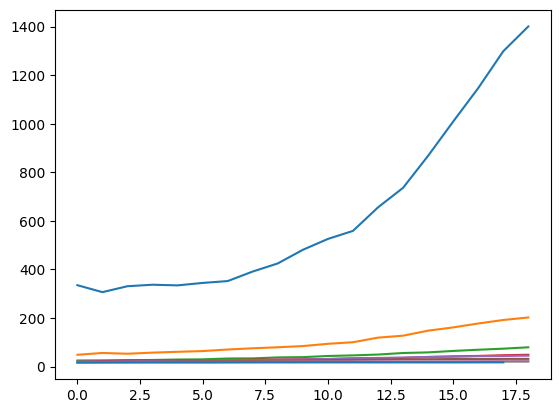

In [111]:
for i in range(1,len(BJs)):
    plt.plot(np.array(Loss[i]))

In [101]:
I=1

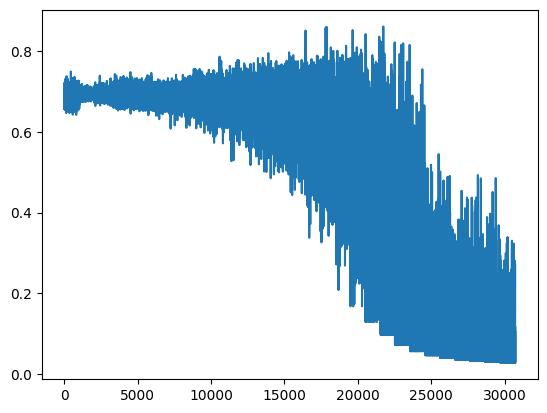

In [104]:
for i in [I]:#range(0,len(BJs)):
    plt.plot(-(np.array(ln_q[i])/N**2))

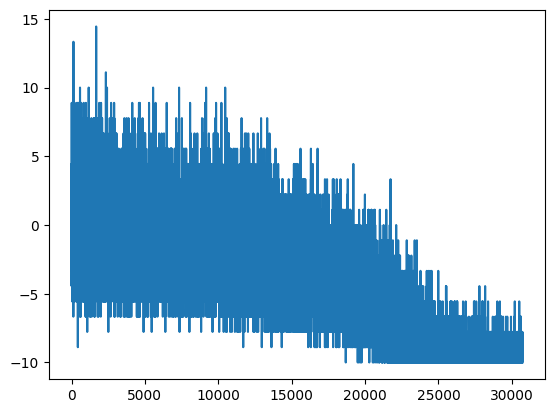

In [105]:
for i in [I]:#range(0,len(BJs)):
    plt.plot(np.array(eneg[i]*BJs[i])/N**2)

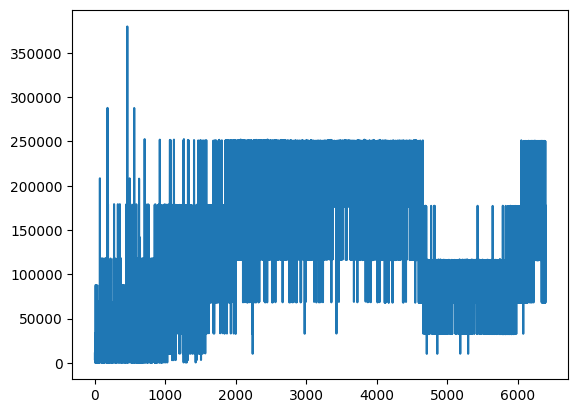

In [1023]:
for i in [I]:#range(0,len(BJs)):
    plt.plot(np.array((eneg[i]*BJs[i] + ln_q[i]))**2/N**2)

Text(0, 0.5, '$S$')

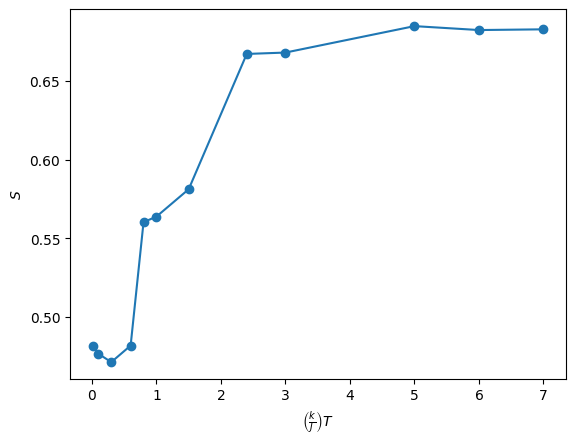

In [121]:
S=np.zeros(len(BJs))
Batch_av_size=1000
for i in range(len(BJs)):
    with torch.no_grad():
        BJs_batch=torch.tensor(np.repeat(BJs[i],Batch_av_size)).type(torch.float32)
        Lattice_batch=torch.tensor(models[i].generate_lattice(torch.zeros((Batch_av_size)),N**2,1)).type(torch.float32)
        # print(I)
        Log_q_batch=models[i](torch.zeros((Batch_av_size)),Lattice_batch)
        # print(Log_q_batch)
        S[i]=-torch.mean(Log_q_batch).item()/N**2
        # print(len(I),I.shape)
        # S[i]=torch.sum(torch.mul(torch.exp(log__q),log__q)).item()
        # print(torch.sum(torch.mul(torch.exp(log__q),log__q)).item())
plt.plot(1/BJs,S)
plt.scatter(1/BJs,S)
plt.xlabel(r'$\left(\frac{k}{J}\right)T$')
plt.ylabel(r'$S$')

Text(0, 0.5, '$S$')

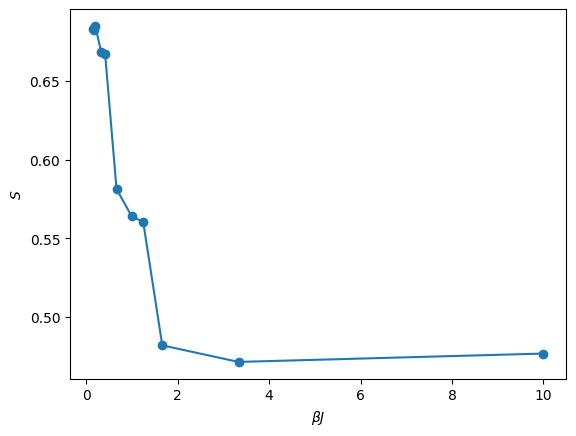

In [122]:
plt.plot(BJs[1:],S[1:])
plt.scatter(BJs[1:],S[1:])
plt.xlabel(r'$\beta J$')
plt.ylabel(r'$S$')

In [123]:
S

array([0.481867  , 0.47662285, 0.47130447, 0.48183367, 0.56031391,
       0.56384987, 0.58126487, 0.6673033 , 0.66818174, 0.68499777,
       0.68250073, 0.68296051])

In [807]:
# testing that sum of all lattice configs is equal to 1

class ProductRNN2(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers=1):
        super(ProductRNN2, self).__init__()
        self.rnn = nn.RNN(input_size+1, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, 2)  # Output 2 numbers: one for each +1, -1

    def forward(self, bj, x):
        x = x.view(x.size(0), -1,1) # flatten + transpose
        # print(((x+1)/2).shape)
        # print(x[:,0:-1,:].shape)
        Zeros=torch.zeros(x.size(0), 1, 1)
        #bj.view(-1,1,1)
        # print(x[:,0:-1,:].shape,Zeros.shape)
        x_0=torch.cat((Zeros,x[:,0:-1,:]), dim=1)
        # print(bj.repeat(x_0.size(1)).view(-1,x_0.size(1),1).shape)
        x_0=torch.cat((x_0,bj.repeat(x_0.size(1)).view(-1,x_0.size(1),1)),dim=2)
        # print(x_0)
        # print(x_0)
        # x_0=torch.cat((Zeros,x[:,0:-1,:]), dim=1)
        # print(bj.view(-1,1,1).shape)
        h0 = torch.zeros(self.rnn.num_layers, x.size(0), self.rnn.hidden_size).to(x.device) # (self.rnn.num_layers, x.size(0), self.rnn.hidden_size) for x=(batch_size, sequence_length, input_size); x.size(0)==batch_size
        # print(x_0[:,:,0].view(16,9,1).shape)
        # print(x_0[:,:,0].view(-1,4,1))
        out, _ = self.rnn(x_0, h0)
        # print(out.shape)
        out = self.fc(out) # for o/p of each time stamp, we have len(hidden_state) o/p. Feeding them to a linear layer and getting single output for each tiemstamp 
        # print(out.shape)
        out = F.log_softmax(out, dim=2) # normalizing o/p at each time stamp
        extracted_values = out.gather(dim=2, index=((x+1)/2).type(torch.int64))
        # print(extracted_values.shape)
        sum_result = extracted_values.sum(dim=1)
        # print(sum_result.shape)
        # print(out)
        
        
        # out = F.softmax(out, dim=2) # normalizing o/p at each time stamp
        # print(out)
        # extracted_values = out.gather(dim=2, index=((x+1)/2).type(torch.int64))
        # print(extracted_values)
        # sum_result = torch.prod(extracted_values,dim=1)
        # print(sum_result.shape)
        return sum_result

    def generate_lattice(self, bj, n_iterations):
        # bj is tensor(0.300) for example
        # Ensure bj is a tensor and has the correct shape
        x=bj.view(-1,1,1)
        Zeros=torch.zeros(x.size(0), 1, 1)
        # print(Zeros.shape,x.shape)
        x=torch.cat((Zeros,x), dim=2)
        # print(x)
        h0 = torch.zeros(self.rnn.num_layers, x.size(0), self.rnn.hidden_size).to(bj.device)
        # Initialize the generated lattice configuration
        generated_lattice = np.zeros((x.size(0),n_iterations))

        with torch.no_grad():
            for i in range(n_iterations):
                # print(x.shape)
                out, h0 = self.rnn(x, h0)
                # print(out)
                # print(h0)
                out = self.fc(out)
                out = F.softmax(out, dim=2)
                # print(out.shape)
                # print(out[:, -1, :].shape)
                # Sample from the output probabilities
                # print(out[:, -1, :])
                sampled_index = torch.multinomial(out[:, -1, :], 1)
                # print(sampled_index.shape)
                # print(sampled_index)
                # Map sampled index to -1 or +1
                x = (2 * sampled_index - 1).float()
    
                # Append the sampled value to the generated lattice
                generated_lattice[:,i]=x.view(-1)
                x=x.view(-1,1,1)
                x=torch.cat((x,bj.view(-1,1,1)), dim=2)
                # print(x)
    
        return generated_lattice.reshape(-1, int(np.sqrt(n_iterations)), int(np.sqrt(n_iterations)))


In [900]:
N = 3

In [901]:
Batch_size=64

T= np.arange(0.01,10,0.6)
BJs=1/T


input_size=1
hidden_size=100
num_layers=1


model = ProductRNN2(input_size, hidden_size, num_layers)

optimizer = optim.Adam(model.parameters(), lr=0.001)

In [902]:
Loss=[[] for i in range(len(BJs))]

In [903]:
# train V2.0
num_epochs = 100
for epoch in range(num_epochs):
    print(f'Epoch {epoch+1}/{num_epochs}:')
    for i in range(len(BJs)):#[len(BJs)-1]:#range(1):#len(BJs)):
        optimizer.zero_grad()
        BJs_batch=torch.tensor(np.repeat(BJs[i],Batch_size)).type(torch.float32)
        # print(BJs_batch.shape)
        Lattice_batch=torch.tensor(model.generate_lattice(BJs_batch,N**2)).type(torch.float32)
        Energy_batch=torch.tensor(Energy(Lattice_batch)).view(-1,1)
        # print(Lattice_batch.shape,Lattice_batch.size(0))
        # print(Energy_batch)
        Log_q_batch=model(BJs_batch,Lattice_batch)
        # print(Log_q_batch.shape, Energy_batch.shape, BJs_batch.shape, BJs_batch.view(-1,1).shape)
        # print(Energy_batch)
        # loss_batch=(Energy_batch*BJs_batch.view(-1,1) + Log_q_batch)**2
        # print(Log_q_batch)
        # print(Energy_batch)
        # loss_batch=-(Log_q_batch + torch.log((Energy_batch*BJs_batch.view(-1,1) + Log_q_batch)**2))
        # print(loss_batch.shape)

        condition=(Energy_batch*BJs_batch.view(-1,1) + Log_q_batch)<0
        for o in condition:
            if o==False:
                print('---')
        positive_loss=-(Log_q_batch + torch.log(-(Energy_batch*BJs_batch.view(-1,1) + Log_q_batch)))
        negative_loss=(Log_q_batch + torch.log((Energy_batch*BJs_batch.view(-1,1) + Log_q_batch)))
        loss_batch = torch.where(condition, positive_loss, negative_loss)

        # print(Log_q_batch)
        # print((Energy_batch*BJs_batch.view(-1,1) + Log_q_batch))
        
        total_loss_batch=loss_batch.mean()/N**2
        total_loss_batch.backward()
        optimizer.step()
        Loss[i].append(total_loss_batch.item())
        # print(Energy_batch)
        # kmds
        print(f'     Batch Loss Model {i}: {total_loss_batch.item()}')

Epoch 1/100:
---
---
---
---
---
---
---
---
---
---
---
---
---
---
---
---
---
---
---
---
---
---
---
---
---
---
---
---
---
---
---
---
---
---
     Batch Loss Model 0: 0.17181222140789032
---
---
---
---
---
---
---
---
---
---
---
---
---
     Batch Loss Model 1: 0.3004206120967865
---
---
---
---
---
---
---
---
---
---
     Batch Loss Model 2: 0.29563456773757935
---
---
---
---
---
     Batch Loss Model 3: 0.4156249761581421
---
     Batch Loss Model 4: 0.4710562527179718
     Batch Loss Model 5: 0.48126542568206787
     Batch Loss Model 6: 0.49112218618392944
     Batch Loss Model 7: 0.48245567083358765
     Batch Loss Model 8: 0.4867900311946869
     Batch Loss Model 9: 0.48506224155426025
     Batch Loss Model 10: 0.48619017004966736
     Batch Loss Model 11: 0.48901763558387756
     Batch Loss Model 12: 0.48286643624305725
     Batch Loss Model 13: 0.4838498532772064
     Batch Loss Model 14: 0.48373112082481384
     Batch Loss Model 15: 0.4847876727581024
     Batch Loss

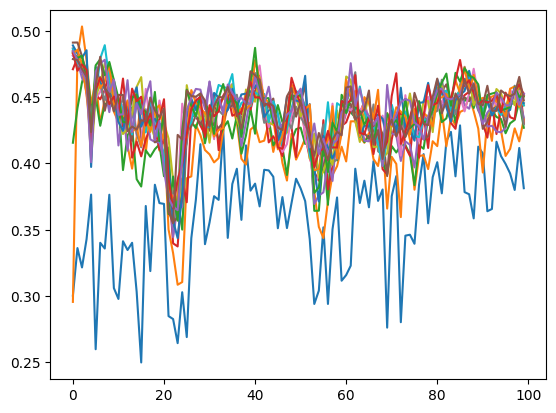

In [904]:
for i in range(1,len(BJs)):
    plt.plot(np.array(Loss[i]))

Text(0, 0.5, '$S$')

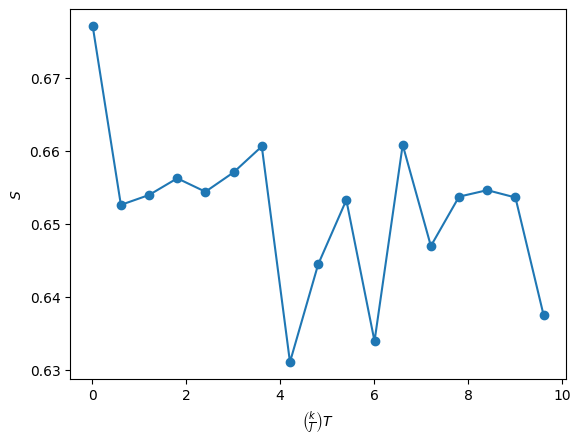

In [905]:
S=np.zeros(len(BJs))
for i in range(len(BJs)):
    with torch.no_grad():
        BJs_batch=torch.tensor(np.repeat(BJs[i],Batch_size)).type(torch.float32)
        # print(BJs_batch)
        Lattice_batch=torch.tensor(model.generate_lattice(BJs_batch,N**2)).type(torch.float32)
        # print(I)
        Log_q_batch=model(BJs_batch,Lattice_batch)
        # print(torch.exp(Log_q_batch)*Log_q_batch)
        S[i]=-torch.mean(Log_q_batch).item()/N**2
        # print(len(I),I.shape)
        # S[i]=torch.sum(torch.mul(torch.exp(log__q),log__q)).item()
        # print(torch.sum(torch.mul(torch.exp(log__q),log__q)).item())
plt.plot(1/BJs,S)
plt.scatter(1/BJs,S)
plt.xlabel(r'$\left(\frac{k}{J}\right)T$')
plt.ylabel(r'$S$')

Text(0, 0.5, '$S$')

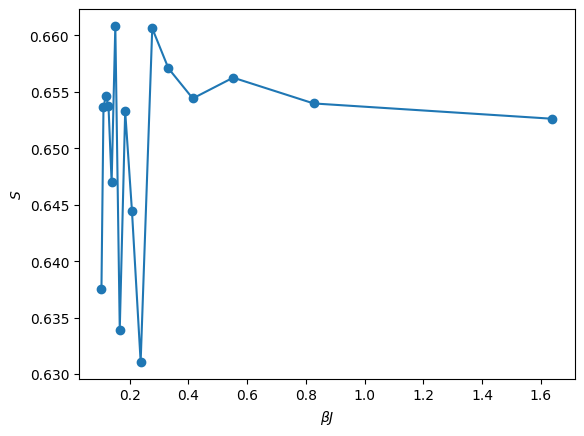

In [906]:
plt.plot(BJs[1:],S[1:])
plt.scatter(BJs[1:],S[1:])
plt.xlabel(r'$\beta J$')
plt.ylabel(r'$S$')

In [889]:
S

array([0.24897658, 0.57244195, 0.56313207, 0.57724026, 0.57272773,
       0.57364305, 0.56411499, 0.56397057, 0.56139289, 0.57788324,
       0.57749091, 0.57788769, 0.57994784, 0.58557298, 0.57879708,
       0.57319758, 0.58347278])

In [147]:
T

array([0.01, 0.61, 1.21, 1.81, 2.41, 3.01, 3.61, 4.21, 4.81, 5.41, 6.01,
       6.61, 7.21, 7.81, 8.41, 9.01, 9.61])

In [820]:
BJs

array([100.        ,   1.63934426,   0.82644628,   0.55248619,
         0.41493776,   0.33222591,   0.27700831,   0.23752969,
         0.20790021,   0.18484288,   0.16638935,   0.15128593,
         0.13869626,   0.12804097,   0.11890606,   0.11098779,
         0.10405827])

In [152]:
BJs[-1]

1.9000000000000001

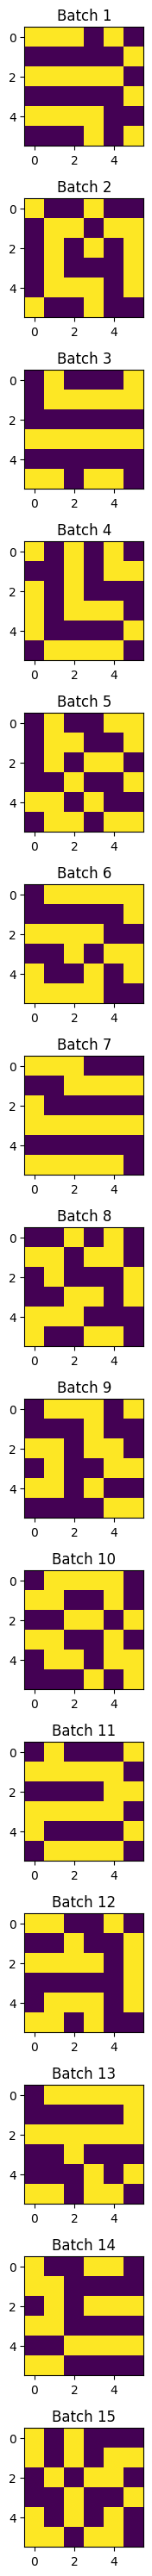

In [131]:
with torch.no_grad():
    Batch_av_size=15
    I=0 # which model number
    BJs_batch=torch.tensor(np.repeat(BJs[I],Batch_av_size)).type(torch.float32) # CHANGE ME
    # BJs_batch=BJs_batch[0:12]
    Lattice_batch=torch.tensor(models[I].generate_lattice(torch.zeros((Batch_av_size)),N**2,1)).type(torch.float32)
    Energy_batch=torch.tensor(Energy(Lattice_batch)).view(-1,1)
    # plt.imshow(Lattice_batch[4])
    # _, rows, cols = Lattice_batch.shape
    fig, axs = plt.subplots(nrows=Batch_av_size, ncols=1, figsize=(6, 2 * Batch_av_size))

    for i in range(Batch_av_size):
        axs[i].imshow(Lattice_batch[i])
        axs[i].set_title(f"Batch {i+1}")
        # print(Energy_batch[i])
        # axs[i].grid(True, which='both', linestyle='--', linewidth=0.5, color='black')

    plt.tight_layout()
    # plt.show()

In [132]:
Energy_batch

tensor([[-32.],
        [-24.],
        [-28.],
        [-28.],
        [-24.],
        [-24.],
        [-20.],
        [-20.],
        [-24.],
        [-24.],
        [-24.],
        [-20.],
        [-20.],
        [-24.],
        [-20.]])